In [538]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import copy

# generate transitions

#  these are fixed
transitions_0 = np.eye(4)
transitions_1 = np.zeros([4,4])
transitions_1[:,-1] = 0.1
transitions_1[-1,-1] = 0

#  these are the ones we want to learn
indices = np.array([[0,1],
                  [0,2],
                  [1,0],
                  [1,2],
                  [2,0],
                  [2,1],
                  [3,0],
                  [3,1]])


transitions_1[indices[:,0],indices[:,1]] = 0.45
transitions_1[3,2] = 0.1
transitions_1

transitions = {0: transitions_0,
               1: transitions_1}

transitions[0], transitions[1]

(array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 array([[0.  , 0.45, 0.45, 0.1 ],
        [0.45, 0.  , 0.45, 0.1 ],
        [0.45, 0.45, 0.  , 0.1 ],
        [0.45, 0.45, 0.1 , 0.  ]]))

In [539]:
def print_progress(states):
    for i in states.keys():
        print(i, states[i].progress, states[i].completed)
        
def get_active_states(states, return_ix=False):
    d = {}
    for s in states.keys():
        if not states[s].completed:
            d[s] =   states[s]
    if return_ix:
        return np.array(list(d.keys()))
    return d


#  Basic reward function
class Reward:
    def __init__(self, states, streaks, streak_length, streak_reward, So_p_reward=0.9):
        self.streaks = streaks
        self.streak_length = streak_length
        self.last_streak_init = 0
        self.states = states
        self.streak_reward = streak_reward
        self.So_p_reward = So_p_reward
        
    def __call__(self, current_state_ix, action_history, n_tasks_completed):
        state = self.states[current_state_ix]
        if action_history[-1]:
            self.last_streak_init = len(action_history)
            return -1

        # if we stay, we might get a reward    
        if state.state_length < 1000: # if we are in task state
            if state.completed: # if task completed, get big money!
                return 100**(n_tasks_completed) + (state.state_length)**2
            else: 
                if self.streaks and (current_state_ix != 3):
                    a = action_history[self.last_streak_init:self.last_streak_init+self.streak_length]
                    if (np.sum(a) == 0) and len(a) == self.streak_length:
                        self.last_streak_init = self.last_streak_init+self.streak_length
                        return self.streak_reward
                return -1
        else: # if we are in other state
            v = npr.binomial(1, self.So_p_reward) # return random reward
#             return 2*(1-v) - v
            return 2*(v) - (1-v)


        
        
# def reward(state, action_history):
#     # if we just switched, always penalize
#     if action_history[-1]:
#         return -1
    
#     # if we stay, we might get a reward    
#     if state.state_length < 1000: # if we are in task state
#         if state.completed: # if task completed, get big money!
#             return 100**(self.n_tasks_completed) + state.state_length
#         else: 
#             return -1
#     else: # if we are in other state
#         v = npr.binomial(1, 0.9) # return random reward
#         return 2*(1-v) - v

    



In [540]:
class Task_Timer:
    def __init__(self, states, on_break, max_decrement=30):
        self.states = states
        self.on_break = on_break
        self.max_decrement = max_decrement
        
    def step(self, current_state_ix, action):
        states = get_active_states(self.states)
        states_ix = get_active_states(self.states, True)
    
        if action: # if we switched, decrement progress of all active states
            for s in states.keys():
                if states[s].n_decrement < self.max_decrement:
                    if not self.on_break:
                        states[s].progress = max(0, states[s].progress -1)
                    states[s].n_decrement += 1
                
        else:
            states[current_state_ix].progress += 1 # increment progress on current state
            
            if states[current_state_ix].progress >= states[current_state_ix].state_length-1: 
                states[current_state_ix].completed = True
                
            
            s_ = np.setdiff1d(states_ix, current_state_ix)
            for i in s_:
                if states[i].n_decrement < self.max_decrement:
                    if not self.on_break:
                        states[i].progress = max(0, states[i].progress-1)
                    states[i].n_decrement += 1
                

            
            
            
        

In [541]:
import numpy.random as npr
import numpy as np

class State:
    def __init__(self, state_length):
        self.state_length = state_length
        self.progress = 0
        self.completed = False
        self.n_decrement = 0

class MDP:
    def __init__(self, 
                 reward, 
                 task_timer, 
                 transitions, 
                 init_state=None, 
                 Break = False, 
                 break_length = 15,
                 Streaks = True, 
                 streak_length = 10,
                 streak_reward = 10,
                 So_reward_p = 0.1):
        '''
        transitions: ()
        init_state: (int)
        '''
        
        # Time Horizon is 8 hours
        self.T = 60*8 
        
        # init states
        self.Ss = State(60)
        self.Sm = State(120)
        self.Sl = State(240)
        self.So = State(10e9) # distracted
        self.states = {0: self.Ss,
                      1: self.Sm,
                      2: self.Sl,
                      3: self.So}
        
        
        self.total_reward = 0
        
        self.init_state = init_state
        if self.init_state is None:
            self.current_state_ix = npr.choice(3) # only start in task state
        else:
            self.current_state_ix = self.init_state
        self.init_s = self.current_state_ix
        
        
        self.init_transition = transitions    
        self.transitions = copy.deepcopy(transitions)
        self.n_tasks_completed = 0
        self.tasks_completed = []
        
        self.Break = Break
        self.on_break = False
        self.break_counter = 0
        self.break_length = break_length
        
        self.task_timer = task_timer(self.states, self.on_break)
        
        
        self.Streaks = Streaks
        self.streak_length = streak_length
        self.streak_reward = streak_reward
        self.So_reward_p = So_reward_p

        self.reward = reward
        self.reward_fn = self.reward(self.states, 
                                self.Streaks, 
                                self.streak_length,
                               self.streak_reward,
                               self.So_reward_p)
        
        self.action_history = []
    
    def __call__(self, action):
        '''Take a step 
        0 is stay
        1 is transition'''
        self.action_history.append(action)
        if action:
            if self.on_break:
                self.on_break = False
                self.task_timer.on_break = False
            # get candidate transitions and probabilities
#             s = get_active_states(self.states, True)
            s = np.setdiff1d(get_active_states(self.states, True),3)
#             self.transitions[1][self.current_state_ix,s] = normalize(self.transitions[1][self.current_state_ix,s])
            norm = 1- self.transitions[1][self.current_state_ix,3].sum()                    
            n = normalize(self.transitions[1][self.current_state_ix,s],norm) 
#             if np.isnan(n).max():
#                 return "ERROR"
            self.transitions[1][self.current_state_ix,s] = n
            n = len(self.transitions[1])
            self.transitions[1][np.arange(n), np.arange(n)] = 0
            
            s = get_active_states(self.states, True)
            p=self.transitions[1][self.current_state_ix, s]
            
#             print(s, p)
            # reset n_decrement
            self.states[self.current_state_ix].n_decrement = 0
            

        
            # randomly sample
            self.current_state_ix = npr.choice(s, p=normalize(p)    )
        else:
            if self.on_break and self.current_state_ix == 3:
                self.break_counter += 1
            
                if self.break_counter >= self.break_length: 
                    # done with break
                    s = np.setdiff1d(get_active_states(self.states, True),3)
#                     self.transitions[1][self.current_state_ix,s] = normalize(self.transitions[1][self.current_state_ix,s])
                    norm = 1- self.transitions[1][self.current_state_ix,3].sum()
    
                    n = normalize(self.transitions[1][self.current_state_ix,s],norm) 
#                     if np.isnan(n).max():
#                         return "ERROR"
                    self.transitions[1][self.current_state_ix,s] = n
                    n = len(self.transitions[1])
                    self.transitions[1][np.arange(n), np.arange(n)] = 0
                    
                    s = get_active_states(self.states, True)
                    p=self.transitions[1][self.current_state_ix, s]
#                     print(s, p)

                    
                    
                    self.current_state_ix = npr.choice(s, p=normalize(p))    
                    self.on_break = False
                    self.task_timer.on_break = False
                    
            pass
        
        self.task_timer.step(self.current_state_ix, action)          
        r = self.reward_fn(self.current_state_ix, self.action_history, self.n_tasks_completed)
        
        # if we complete the task, sample a new task
        if self.states[self.current_state_ix].completed:
            self.tasks_completed.append(self.current_state_ix)
#             s = get_active_states(self.states, True)
            s = np.setdiff1d(get_active_states(self.states, True),3)
#             self.transitions[1][self.current_state_ix,s] = normalize(self.transitions[1][self.current_state_ix,s])
            norm = 1- self.transitions[1][self.current_state_ix,3].sum()
            n = normalize(self.transitions[1][self.current_state_ix,s],norm) 
#             if np.isnan(n).max():
#                 return "ERROR"
            
            self.transitions[1][self.current_state_ix,s] = n
            n = len(self.transitions[1])
            self.transitions[1][np.arange(n), np.arange(n)] = 0
            
            s = get_active_states(self.states, True)
            p = self.transitions[1][self.current_state_ix,s]
            
#             print(s, p)
            self.current_state_ix = npr.choice(s, p=normalize(p))
            self.n_tasks_completed += 1
            
            
            
            if self.Break:
                self.current_state_ix = 3
                self.on_break = True
                self.task_timer.on_break = True
                self.break_counter = 0
                
            
        self.total_reward += r
        return self.current_state_ix, r
    
    def get_state_ix(self):
        return self.current_state_ix
    
    def get_state(self):
        return self.states[self.current_state_ix]
    
    def reset(self):
        self.Ss = State(60)
        self.Sm = State(120)
        self.Sl = State(240)
        self.So = State(10e9) # distracted
        self.states = {0: self.Ss,
                      1: self.Sm,
                      2: self.Sl,
                      3: self.So}
        
        
        self.total_reward = 0
        
        
        if self.init_state is None:
            self.current_state_ix = npr.choice(3) # only start in task state
        else:
            self.current_state_ix = self.init_state
        
        self.init_s = self.current_state_ix
            
        self.transitions = copy.deepcopy(self.init_transition)
        self.n_tasks_completed = 0
        self.action_history = []
        
        self.on_break = False
        
        self.task_timer.states = self.states
        self.task_timer.on_break = self.on_break
        
        self.reward_fn.states = self.states
        self.tasks_completed = []


        
# def normalize(p):
#     return p/p.sum()

def normalize(p, norm=1):
#     p_ = p[:-1]
#     return p_/p_.sum()*(1-p[-1])
    return p/p.sum()*norm

def fake_agent(s, r):
    # random action
    return npr.choice(2, p=[0.99, 0.01])


mdp = MDP(Reward, 
          Task_Timer,  
          transitions, 
          None, 
          Break=False, 
          Streaks=False)
self = mdp
    
    

    
        
        

In [542]:
class Agent:
    def __init__(self, 
                 discount_factor = 0.9,
                 learning_rate = 0.9,
                 weight_1 = 0.2, 
                 weight_2 = 0.1, 
                 weight_3 = 0.2,
                 weight_4 = 0.1,
                 a = 0,
                 epsilon = 0.05):
        
        self.Qn = npr.randn(4, 2)*0.01
        self.Qp = npr.randn(4, 2)*0.01
        self.Q = np.zeros((4, 2))

        self.weight_1 = weight_1
        self.weight_2 = weight_2
        self.weight_3 = weight_3
        self.weight_4 = weight_4
        
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        
        self.a = 0
        
        self.epsilon = epsilon
        

#     def choose_action(self, s, r):
#         s_idx = mdp.get_state_ix()
        
#         # TODO: check that not all states are complete
#         self.Q[s_idx, self.a] = self.weight_2 * self.Qp[s_idx, self.a] + self.weight_4 * self.Qn[s_idx, self.a]
#         self.a = np.argmax(self.Q[s_idx])
#         new_s,_ = mdp(self.a)
#         new_s_idx = mdp.get_state_ix()

#         self.Qp[s_idx, self.a] = self.weight_1 * self.Qp[s_idx, self.a] + self.learning_rate * (r + self.discount_factor * np.max(self.Qp[new_s_idx]) - self.Qp[s_idx, self.a])
#         self.Qn[s_idx, self.a] = self.weight_3 * self.Qn[s_idx, self.a] + self.learning_rate * (r + self.discount_factor * np.max(self.Qn[new_s_idx]) - self.Qn[s_idx, self.a])

#         return np.argmax(self.Q[s_idx]) 
    
    def choose_action(self, s_idx):
        p = np.random.random()
        if p < self.epsilon:
          return np.random.choice([0,1]) 
        else:
          return np.argmax(self.Q[s_idx])
        
    def update(self, s0_idx, s1_idx, r):
        
        # TODO: check that not all states are complete
        self.Q[s0_idx, self.a] = self.weight_2 * self.Qp[s0_idx, self.a] + self.weight_4 * self.Qn[s0_idx, self.a]
        
        self.a = np.argmax(self.Q[s0_idx])

        if r > 0: 
            self.Qp[s0_idx, self.a] = self.weight_1 * self.Qp[s0_idx, self.a] + self.learning_rate * (r + self.discount_factor * np.max(self.Qp[s1_idx]) - self.Qp[s0_idx, self.a])
        else:
            self.Qn[s0_idx, self.a] = self.weight_3 * self.Qn[s0_idx, self.a] + self.learning_rate * (r + self.discount_factor * np.max(self.Qn[s1_idx]) - self.Qn[s0_idx, self.a])
        
    def reset(self,):
        self.Qn = npr.random((4, 2))*0.1
        self.Qp = npr.random((4, 2))*0.1
        self.a = 0
        self.Q = npr.random((4, 2))

In [543]:
class Episodes:
    def __init__(self, mdp, agent, n_episodes, verbose=True):
        self.mdp = mdp
        self.agent = agent
        self.EPISODES_NUM = n_episodes
        self.prog = [[] for _ in range(self.EPISODES_NUM)]
        self.actions = [[] for _ in range(self.EPISODES_NUM)]
        self.states = [[] for _ in range(self.EPISODES_NUM)]
        self.rewards = [[] for _ in range(self.EPISODES_NUM)]
        self.on_break = [[] for _ in range(self.EPISODES_NUM)]
        self.score = [[] for _ in range(self.EPISODES_NUM)]
        self.tasks_completed = [[] for _ in range(self.EPISODES_NUM)]
        self.init_states = [[] for _ in range(self.EPISODES_NUM)]
        self.time_horizon = 480
        
        self.verbose= verbose
        
        
    def run(self, ):
        if self.verbose:
            print(f"Running {self.EPISODES_NUM} episodes")
        for i in range(self.EPISODES_NUM):
            self.mdp.reset() # reset mdp for every episode
#             self.agent.reset() # reset agent for every episode
            
            
            s0 = self.mdp.get_state_ix()
            for j in range(self.time_horizon):

                a = self.agent.choose_action(s0)
                s1, r = self.mdp(a)
                s1 = self.mdp.get_state_ix()
                self.agent.update(s0, s1, r)
                s0 = s1

                p_ = [mdp.states[k].progress for k in range(4)]

                self.prog[i].append(p_)
                self.actions[i].append(a)
                self.states[i].append(self.mdp.current_state_ix)
                self.rewards[i].append(r)
                self.on_break[i].append(self.mdp.on_break)
                

                active_states = get_active_states(self.mdp.states,True)
                if len(active_states) == 1:
                    break
#             print(self.mdp.transitions)
            self.init_states[i].append(self.mdp.init_s)
            self.tasks_completed[i].append(self.mdp.tasks_completed)
                    
            self.score[i] = np.sum(self.rewards[i])
            if self.verbose:
                print(f"\tEpisode: {i}\tScore: {self.score[i]}")
                
#             print(self.mdp.transitions)

In [544]:
episode.mdp.transitions

{0: array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 1: array([[0.  , 0.45, 0.45, 0.1 ],
        [0.45, 0.  , 0.45, 0.1 ],
        [0.45, 0.45, 0.  , 0.1 ],
        [0.45, 0.45, 0.1 , 0.  ]])}

## Bar plot 1: tasks completed per setting

In [545]:
def get_bary(episode):
    bary = np.zeros(3)
    
    x = np.concatenate([i[0] for i in episode.tasks_completed if len(i[0]) > 0])

    u, c = np.unique(x, return_counts=True)
    o = np.setdiff1d(np.arange(3), u)


    for i,j  in zip(u, c):
        bary[i] = j

    for i in o:
        bary[i] = 0
        
    return bary


In [552]:
self = mdp
self.transitions

{0: array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 1: array([[0.  , 0.45, 0.45, 0.1 ],
        [0.45, 0.  , 0.45, 0.1 ],
        [0.45, 0.45, 0.  , 0.1 ],
        [0.45, 0.45, 0.1 , 0.  ]])}

In [648]:

import time
    
# have a way of constructing valid transition matrices so that each row is a valid probability. 
# How many "sliders" or "knobs" do you need? 


t1 = time.time()
initial_state = None

mdp = MDP(Reward, 
          Task_Timer,  
          transitions, 
          initial_state, 
          Break=False,
          break_length = 10,
          Streaks=False,
         streak_length=10)

agent = Agent(epsilon=0.10, learning_rate=0.1) # epsilon is the probability of "exploring" vs exploiting
n_episodes = 1000
episode = Episodes(mdp, agent, n_episodes)
episode.run()
time.time() - t1

bary1 = get_bary(episode)

Running 1000 episodes
	Episode: 0	Score: 3122
	Episode: 1	Score: 3122
	Episode: 2	Score: -480
	Episode: 3	Score: 3122
	Episode: 4	Score: 17623
	Episode: 5	Score: 3134
	Episode: 6	Score: -462
	Episode: 7	Score: -471
	Episode: 8	Score: -480


/var/folders/sg/6wtlzgws3s53sr8zwb1lxs3w0000gn/T/ipykernel_43875/3344027902.py:224: RuntimeWarning: invalid value encountered in divide
  return p/p.sum()*norm


	Episode: 9	Score: -477
	Episode: 10	Score: -459
	Episode: 11	Score: -471
	Episode: 12	Score: -474
	Episode: 13	Score: 3128
	Episode: 14	Score: 3134
	Episode: 15	Score: 3134
	Episode: 16	Score: -480
	Episode: 17	Score: -477
	Episode: 18	Score: -477
	Episode: 19	Score: 17641
	Episode: 20	Score: 3134
	Episode: 21	Score: 3143
	Episode: 22	Score: 3164
	Episode: 23	Score: 3128
	Episode: 24	Score: -450
	Episode: 25	Score: -480
	Episode: 26	Score: -462
	Episode: 27	Score: -480
	Episode: 28	Score: -468
	Episode: 29	Score: -477
	Episode: 30	Score: 3122
	Episode: 31	Score: 17626
	Episode: 32	Score: 3122
	Episode: 33	Score: -471
	Episode: 34	Score: 3128
	Episode: 35	Score: 3140
	Episode: 36	Score: -459
	Episode: 37	Score: 17638
	Episode: 38	Score: -477
	Episode: 39	Score: 3137
	Episode: 40	Score: -474
	Episode: 41	Score: 3128
	Episode: 42	Score: -465
	Episode: 43	Score: 3122
	Episode: 44	Score: -465
	Episode: 45	Score: 3137
	Episode: 46	Score: -477
	Episode: 47	Score: 3146
	Episode: 48	Score: 313

	Episode: 327	Score: 3122
	Episode: 328	Score: -453
	Episode: 329	Score: -468
	Episode: 330	Score: -468
	Episode: 331	Score: 13961
	Episode: 332	Score: -459
	Episode: 333	Score: -474
	Episode: 334	Score: 17626
	Episode: 335	Score: -438
	Episode: 336	Score: -477
	Episode: 337	Score: 3140
	Episode: 338	Score: 3122
	Episode: 339	Score: 3137
	Episode: 340	Score: 3122
	Episode: 341	Score: 3140
	Episode: 342	Score: -471
	Episode: 343	Score: 3143
	Episode: 344	Score: -471
	Episode: 345	Score: -471
	Episode: 346	Score: 13931
	Episode: 347	Score: -474
	Episode: 348	Score: -459
	Episode: 349	Score: 3137
	Episode: 350	Score: -474
	Episode: 351	Score: 3137
	Episode: 352	Score: 17653
	Episode: 353	Score: -453
	Episode: 354	Score: 17650
	Episode: 355	Score: -471
	Episode: 356	Score: 3125
	Episode: 357	Score: -480
	Episode: 358	Score: 17650
	Episode: 359	Score: -465
	Episode: 360	Score: -459
	Episode: 361	Score: -474
	Episode: 362	Score: -474
	Episode: 363	Score: -471
	Episode: 364	Score: 3131
	Episo

	Episode: 642	Score: -480
	Episode: 643	Score: -474
	Episode: 644	Score: 3143
	Episode: 645	Score: -471
	Episode: 646	Score: -480
	Episode: 647	Score: -474
	Episode: 648	Score: -468
	Episode: 649	Score: -480
	Episode: 650	Score: 3122
	Episode: 651	Score: -480
	Episode: 652	Score: -456
	Episode: 653	Score: 3125
	Episode: 654	Score: 3125
	Episode: 655	Score: 3125
	Episode: 656	Score: 13922
	Episode: 657	Score: -474
	Episode: 658	Score: 3134
	Episode: 659	Score: -468
	Episode: 660	Score: -480
	Episode: 661	Score: 3122
	Episode: 662	Score: -477
	Episode: 663	Score: -477
	Episode: 664	Score: -471
	Episode: 665	Score: -480
	Episode: 666	Score: -447
	Episode: 667	Score: -480
	Episode: 668	Score: 3137
	Episode: 669	Score: 3128
	Episode: 670	Score: 17629
	Episode: 671	Score: 3146
	Episode: 672	Score: -468
	Episode: 673	Score: 3125
	Episode: 674	Score: 3131
	Episode: 675	Score: 3125
	Episode: 676	Score: 3146
	Episode: 677	Score: 3128
	Episode: 678	Score: 3128
	Episode: 679	Score: 3131
	Episode: 

	Episode: 967	Score: 3131
	Episode: 968	Score: -456
	Episode: 969	Score: -456
	Episode: 970	Score: -480
	Episode: 971	Score: 3122
	Episode: 972	Score: 13931
	Episode: 973	Score: 3131
	Episode: 974	Score: -471
	Episode: 975	Score: -471
	Episode: 976	Score: -441
	Episode: 977	Score: -480
	Episode: 978	Score: 3122
	Episode: 979	Score: 3137
	Episode: 980	Score: -480
	Episode: 981	Score: -447
	Episode: 982	Score: 3146
	Episode: 983	Score: 17632
	Episode: 984	Score: 3128
	Episode: 985	Score: 3131
	Episode: 986	Score: 17623
	Episode: 987	Score: 3146
	Episode: 988	Score: -465
	Episode: 989	Score: -468
	Episode: 990	Score: -450
	Episode: 991	Score: -471
	Episode: 992	Score: 3137
	Episode: 993	Score: 3122
	Episode: 994	Score: 3122
	Episode: 995	Score: 13928
	Episode: 996	Score: 3134
	Episode: 997	Score: 3134
	Episode: 998	Score: 3131
	Episode: 999	Score: 3131


In [649]:
bary1, bary2

(array([477.,  88.,   1.]), array([870.,   0., 469.]))

In [642]:

import time
    
# have a way of constructing valid transition matrices so that each row is a valid probability. 
# How many "sliders" or "knobs" do you need? 


t1 = time.time()
initial_state = None

mdp = MDP(Reward, 
          Task_Timer,  
          transitions, 
          initial_state, 
          Break=True,
          break_length = 10,
          Streaks=False,
         streak_length=10)

agent = Agent(epsilon=0.1, learning_rate=0.1) # epsilon is the probability of "exploring" vs exploiting
n_episodes = 1000
episode = Episodes(mdp, agent, n_episodes)
episode.run()
time.time() - t1

bary2 = get_bary(episode)

Running 1000 episodes
	Episode: 0	Score: 60823
	Episode: 1	Score: 3122
	Episode: 2	Score: 60823
	Episode: 3	Score: 60829
	Episode: 4	Score: 60823
	Episode: 5	Score: 60823
	Episode: 6	Score: -480
	Episode: 7	Score: -480
	Episode: 8	Score: 3122


/var/folders/sg/6wtlzgws3s53sr8zwb1lxs3w0000gn/T/ipykernel_43875/3344027902.py:224: RuntimeWarning: invalid value encountered in divide
  return p/p.sum()*norm


	Episode: 9	Score: 60823
	Episode: 10	Score: 60823
	Episode: 11	Score: -480
	Episode: 12	Score: 60823
	Episode: 13	Score: 3122
	Episode: 14	Score: 60823
	Episode: 15	Score: 3122
	Episode: 16	Score: 3122
	Episode: 17	Score: 3122
	Episode: 18	Score: 3122
	Episode: 19	Score: 60826
	Episode: 20	Score: 60826
	Episode: 21	Score: 60823
	Episode: 22	Score: 60826
	Episode: 23	Score: 60823
	Episode: 24	Score: 60823
	Episode: 25	Score: 60823
	Episode: 26	Score: 60826
	Episode: 27	Score: 3122
	Episode: 28	Score: 60823
	Episode: 29	Score: 60823
	Episode: 30	Score: 60823
	Episode: 31	Score: 60823
	Episode: 32	Score: 3122
	Episode: 33	Score: 3122
	Episode: 34	Score: 3122
	Episode: 35	Score: 3125
	Episode: 36	Score: 60823
	Episode: 37	Score: -480
	Episode: 38	Score: 3122
	Episode: 39	Score: 60823
	Episode: 40	Score: 60826
	Episode: 41	Score: 3122
	Episode: 42	Score: 60823
	Episode: 43	Score: 60826
	Episode: 44	Score: 60823
	Episode: 45	Score: 60823
	Episode: 46	Score: -480
	Episode: 47	Score: 3122
	Ep

	Episode: 329	Score: 60823
	Episode: 330	Score: 3122
	Episode: 331	Score: 60823
	Episode: 332	Score: 60826
	Episode: 333	Score: 3122
	Episode: 334	Score: 60823
	Episode: 335	Score: 3122
	Episode: 336	Score: 3122
	Episode: 337	Score: 60829
	Episode: 338	Score: 60823
	Episode: 339	Score: 3122
	Episode: 340	Score: 60823
	Episode: 341	Score: 60823
	Episode: 342	Score: 3122
	Episode: 343	Score: -480
	Episode: 344	Score: 3122
	Episode: 345	Score: 3122
	Episode: 346	Score: 60823
	Episode: 347	Score: 3122
	Episode: 348	Score: 3122
	Episode: 349	Score: 60823
	Episode: 350	Score: 60823
	Episode: 351	Score: 60823
	Episode: 352	Score: 3122
	Episode: 353	Score: -480
	Episode: 354	Score: 60823
	Episode: 355	Score: 60823
	Episode: 356	Score: 3125
	Episode: 357	Score: 3122
	Episode: 358	Score: 3122
	Episode: 359	Score: 3122
	Episode: 360	Score: 3122
	Episode: 361	Score: 60823
	Episode: 362	Score: 60823
	Episode: 363	Score: 60826
	Episode: 364	Score: 3122
	Episode: 365	Score: 60823
	Episode: 366	Score:

	Episode: 646	Score: 3122
	Episode: 647	Score: -480
	Episode: 648	Score: 60823
	Episode: 649	Score: 60823
	Episode: 650	Score: 3122
	Episode: 651	Score: -480
	Episode: 652	Score: 60823
	Episode: 653	Score: 3122
	Episode: 654	Score: 60823
	Episode: 655	Score: -480
	Episode: 656	Score: 60826
	Episode: 657	Score: 3122
	Episode: 658	Score: 60826
	Episode: 659	Score: 3122
	Episode: 660	Score: 60823
	Episode: 661	Score: -480
	Episode: 662	Score: 3122
	Episode: 663	Score: 3122
	Episode: 664	Score: 60826
	Episode: 665	Score: 3122
	Episode: 666	Score: 60823
	Episode: 667	Score: 60826
	Episode: 668	Score: 3122
	Episode: 669	Score: 3122
	Episode: 670	Score: 60823
	Episode: 671	Score: 60823
	Episode: 672	Score: 3122
	Episode: 673	Score: -480
	Episode: 674	Score: 3122
	Episode: 675	Score: 3122
	Episode: 676	Score: 60823
	Episode: 677	Score: -480
	Episode: 678	Score: 60823
	Episode: 679	Score: 3125
	Episode: 680	Score: 3122
	Episode: 681	Score: 3122
	Episode: 682	Score: 60823
	Episode: 683	Score: 60

	Episode: 965	Score: 60823
	Episode: 966	Score: -480
	Episode: 967	Score: 60823
	Episode: 968	Score: 60823
	Episode: 969	Score: 60823
	Episode: 970	Score: 3122
	Episode: 971	Score: 3122
	Episode: 972	Score: 60823
	Episode: 973	Score: 3122
	Episode: 974	Score: 60823
	Episode: 975	Score: 60823
	Episode: 976	Score: 60823
	Episode: 977	Score: 60823
	Episode: 978	Score: 60826
	Episode: 979	Score: 3122
	Episode: 980	Score: 3122
	Episode: 981	Score: 60823
	Episode: 982	Score: 3122
	Episode: 983	Score: -480
	Episode: 984	Score: 3122
	Episode: 985	Score: 60826
	Episode: 986	Score: 3122
	Episode: 987	Score: 60823
	Episode: 988	Score: 3122
	Episode: 989	Score: -480
	Episode: 990	Score: 3122
	Episode: 991	Score: 60823
	Episode: 992	Score: 3122
	Episode: 993	Score: 60823
	Episode: 994	Score: 60826
	Episode: 995	Score: 60823
	Episode: 996	Score: 60823
	Episode: 997	Score: 60826
	Episode: 998	Score: 3122
	Episode: 999	Score: -480


In [625]:

import time
    
# have a way of constructing valid transition matrices so that each row is a valid probability. 
# How many "sliders" or "knobs" do you need? 


t1 = time.time()
initial_state = None

mdp = MDP(Reward, 
          Task_Timer,  
          transitions, 
          initial_state, 
          Break=False,
          break_length = 10,
          Streaks=True,
         streak_length=10)

agent = Agent(epsilon=0.1, learning_rate=1.1) # epsilon is the probability of "exploring" vs exploiting
n_episodes = 1000
episode = Episodes(mdp, agent, n_episodes)
episode.run()
time.time() - t1

bary3 = get_bary(episode)

Running 1000 episodes
	Episode: 0	Score: 3485
	Episode: 1	Score: 3507
	Episode: 2	Score: 3518
	Episode: 3	Score: 3496
	Episode: 4	Score: 17997
	Episode: 5	Score: -84
	Episode: 6	Score: 3496
	Episode: 7	Score: -128


/var/folders/sg/6wtlzgws3s53sr8zwb1lxs3w0000gn/T/ipykernel_43875/3344027902.py:224: RuntimeWarning: invalid value encountered in divide
  return p/p.sum()*norm


	Episode: 8	Score: 14318
	Episode: 9	Score: 3507
	Episode: 10	Score: -161
	Episode: 11	Score: -150
	Episode: 12	Score: -106
	Episode: 13	Score: 3485
	Episode: 14	Score: 3573
	Episode: 15	Score: -106
	Episode: 16	Score: -84
	Episode: 17	Score: 3507
	Episode: 18	Score: -117
	Episode: 19	Score: 3463
	Episode: 20	Score: -172
	Episode: 21	Score: -150
	Episode: 22	Score: -117
	Episode: 23	Score: 3485
	Episode: 24	Score: -106
	Episode: 25	Score: -73
	Episode: 26	Score: 17986
	Episode: 27	Score: -161
	Episode: 28	Score: 18008
	Episode: 29	Score: 3507
	Episode: 30	Score: 3529
	Episode: 31	Score: 3529
	Episode: 32	Score: -106
	Episode: 33	Score: -95
	Episode: 34	Score: -161
	Episode: 35	Score: -117
	Episode: 36	Score: 3463
	Episode: 37	Score: -84
	Episode: 38	Score: 17986
	Episode: 39	Score: 3507
	Episode: 40	Score: 3507
	Episode: 41	Score: 3485
	Episode: 42	Score: -62
	Episode: 43	Score: 3529
	Episode: 44	Score: 3474
	Episode: 45	Score: 3496
	Episode: 46	Score: 3452
	Episode: 47	Score: 3452
	Ep

	Episode: 328	Score: -95
	Episode: 329	Score: -106
	Episode: 330	Score: 18030
	Episode: 331	Score: 3507
	Episode: 332	Score: -84
	Episode: 333	Score: 3518
	Episode: 334	Score: 3518
	Episode: 335	Score: -106
	Episode: 336	Score: 3507
	Episode: 337	Score: -84
	Episode: 338	Score: 3488
	Episode: 339	Score: -139
	Episode: 340	Score: 14329
	Episode: 341	Score: -150
	Episode: 342	Score: 3507
	Episode: 343	Score: -95
	Episode: 344	Score: 3507
	Episode: 345	Score: -106
	Episode: 346	Score: 3540
	Episode: 347	Score: -128
	Episode: 348	Score: 3529
	Episode: 349	Score: 3573
	Episode: 350	Score: 3507
	Episode: 351	Score: 3496
	Episode: 352	Score: -150
	Episode: 353	Score: 18030
	Episode: 354	Score: -205
	Episode: 355	Score: -128
	Episode: 356	Score: -161
	Episode: 357	Score: 3452
	Episode: 358	Score: 3485
	Episode: 359	Score: -62
	Episode: 360	Score: 18019
	Episode: 361	Score: -73
	Episode: 362	Score: 3463
	Episode: 363	Score: 3496
	Episode: 364	Score: 3496
	Episode: 365	Score: -117
	Episode: 366	

	Episode: 644	Score: -128
	Episode: 645	Score: -128
	Episode: 646	Score: 3562
	Episode: 647	Score: 3474
	Episode: 648	Score: -95
	Episode: 649	Score: -117
	Episode: 650	Score: 3496
	Episode: 651	Score: -106
	Episode: 652	Score: -84
	Episode: 653	Score: 3474
	Episode: 654	Score: -172
	Episode: 655	Score: -106
	Episode: 656	Score: 3540
	Episode: 657	Score: 3507
	Episode: 658	Score: 3507
	Episode: 659	Score: 18019
	Episode: 660	Score: 3463
	Episode: 661	Score: 3540
	Episode: 662	Score: 3540
	Episode: 663	Score: 3485
	Episode: 664	Score: 3507
	Episode: 665	Score: -95
	Episode: 666	Score: -139
	Episode: 667	Score: -172
	Episode: 668	Score: -139
	Episode: 669	Score: -194
	Episode: 670	Score: 3540
	Episode: 671	Score: 3474
	Episode: 672	Score: -106
	Episode: 673	Score: 14208
	Episode: 674	Score: -84
	Episode: 675	Score: -139
	Episode: 676	Score: 3419
	Episode: 677	Score: -95
	Episode: 678	Score: -106
	Episode: 679	Score: -117
	Episode: 680	Score: 18008
	Episode: 681	Score: 3507
	Episode: 682	

	Episode: 961	Score: -128
	Episode: 962	Score: 3529
	Episode: 963	Score: -106
	Episode: 964	Score: -95
	Episode: 965	Score: 3474
	Episode: 966	Score: -73
	Episode: 967	Score: 14329
	Episode: 968	Score: -150
	Episode: 969	Score: -128
	Episode: 970	Score: -95
	Episode: 971	Score: -117
	Episode: 972	Score: 3463
	Episode: 973	Score: 3474
	Episode: 974	Score: -84
	Episode: 975	Score: 14285
	Episode: 976	Score: 3474
	Episode: 977	Score: 18052
	Episode: 978	Score: 3551
	Episode: 979	Score: 17934
	Episode: 980	Score: -73
	Episode: 981	Score: -161
	Episode: 982	Score: 3485
	Episode: 983	Score: -117
	Episode: 984	Score: 14384
	Episode: 985	Score: -73
	Episode: 986	Score: -95
	Episode: 987	Score: -106
	Episode: 988	Score: -95
	Episode: 989	Score: 17964
	Episode: 990	Score: -84
	Episode: 991	Score: 3507
	Episode: 992	Score: 14296
	Episode: 993	Score: -117
	Episode: 994	Score: -117
	Episode: 995	Score: -95
	Episode: 996	Score: -128
	Episode: 997	Score: 18074
	Episode: 998	Score: -117
	Episode: 999	

In [618]:
bary3, bary4

(array([  0.,   0., 376.]), array([  0.,   0., 367.]))

In [636]:

import time
    
# have a way of constructing valid transition matrices so that each row is a valid probability. 
# How many "sliders" or "knobs" do you need? 


t1 = time.time()
initial_state = 0

mdp = MDP(Reward, 
          Task_Timer,  
          transitions, 
          initial_state, 
          Break=False,
          break_length = 10,
          Streaks=False,
         streak_length=10)

agent = Agent(epsilon=0.1, learning_rate=0.1) # epsilon is the probability of "exploring" vs exploiting
n_episodes = 1000
episode = Episodes(mdp, agent, n_episodes)
episode.run()
time.time() - t1

bary4 = get_bary(episode)

Running 1000 episodes
	Episode: 0	Score: 3125
	Episode: 1	Score: 60823
	Episode: 2	Score: 3122
	Episode: 3	Score: 3122
	Episode: 4	Score: 60823
	Episode: 5	Score: 60823
	Episode: 6	Score: 3122
	Episode: 7	Score: 60823


/var/folders/sg/6wtlzgws3s53sr8zwb1lxs3w0000gn/T/ipykernel_43875/3344027902.py:224: RuntimeWarning: invalid value encountered in divide
  return p/p.sum()*norm


	Episode: 8	Score: 60823
	Episode: 9	Score: 60826
	Episode: 10	Score: 60826
	Episode: 11	Score: 60823
	Episode: 12	Score: 60823
	Episode: 13	Score: 60823
	Episode: 14	Score: 60823
	Episode: 15	Score: 3122
	Episode: 16	Score: 3122
	Episode: 17	Score: 3122
	Episode: 18	Score: 60823
	Episode: 19	Score: -480
	Episode: 20	Score: 3122
	Episode: 21	Score: 60823
	Episode: 22	Score: 60826
	Episode: 23	Score: 3122
	Episode: 24	Score: 60823
	Episode: 25	Score: -480
	Episode: 26	Score: 60823
	Episode: 27	Score: 3122
	Episode: 28	Score: 3122
	Episode: 29	Score: 60823
	Episode: 30	Score: 3122
	Episode: 31	Score: 3122
	Episode: 32	Score: -480
	Episode: 33	Score: 60823
	Episode: 34	Score: 3122
	Episode: 35	Score: 3122
	Episode: 36	Score: 3122
	Episode: 37	Score: 60823
	Episode: 38	Score: 60823
	Episode: 39	Score: 60823
	Episode: 40	Score: 60823
	Episode: 41	Score: 3122
	Episode: 42	Score: 60823
	Episode: 43	Score: -480
	Episode: 44	Score: 60823
	Episode: 45	Score: 3122
	Episode: 46	Score: 3122
	Episod

	Episode: 322	Score: 3122
	Episode: 323	Score: 60823
	Episode: 324	Score: 3122
	Episode: 325	Score: 3122
	Episode: 326	Score: 3122
	Episode: 327	Score: -480
	Episode: 328	Score: 60823
	Episode: 329	Score: 3122
	Episode: 330	Score: 3122
	Episode: 331	Score: 3122
	Episode: 332	Score: 3122
	Episode: 333	Score: 3122
	Episode: 334	Score: 60826
	Episode: 335	Score: 60823
	Episode: 336	Score: -480
	Episode: 337	Score: 3122
	Episode: 338	Score: 60823
	Episode: 339	Score: 60826
	Episode: 340	Score: 3122
	Episode: 341	Score: 60823
	Episode: 342	Score: 3122
	Episode: 343	Score: 3122
	Episode: 344	Score: 3122
	Episode: 345	Score: 60823
	Episode: 346	Score: -480
	Episode: 347	Score: 60823
	Episode: 348	Score: 60826
	Episode: 349	Score: -480
	Episode: 350	Score: 3122
	Episode: 351	Score: 3122
	Episode: 352	Score: 60826
	Episode: 353	Score: 3122
	Episode: 354	Score: 60823
	Episode: 355	Score: 3122
	Episode: 356	Score: 3122
	Episode: 357	Score: 60823
	Episode: 358	Score: 60823
	Episode: 359	Score: 312

	Episode: 636	Score: 3122
	Episode: 637	Score: -480
	Episode: 638	Score: 60823
	Episode: 639	Score: 3122
	Episode: 640	Score: 60823
	Episode: 641	Score: 60823
	Episode: 642	Score: 3122
	Episode: 643	Score: 60826
	Episode: 644	Score: 60823
	Episode: 645	Score: 60823
	Episode: 646	Score: -480
	Episode: 647	Score: -480
	Episode: 648	Score: 3122
	Episode: 649	Score: 3122
	Episode: 650	Score: -480
	Episode: 651	Score: 60826
	Episode: 652	Score: 60823
	Episode: 653	Score: 3122
	Episode: 654	Score: 60823
	Episode: 655	Score: 3122
	Episode: 656	Score: 60823
	Episode: 657	Score: 60823
	Episode: 658	Score: 3122
	Episode: 659	Score: 60823
	Episode: 660	Score: 3122
	Episode: 661	Score: 3122
	Episode: 662	Score: 60823
	Episode: 663	Score: 3122
	Episode: 664	Score: 3122
	Episode: 665	Score: -480
	Episode: 666	Score: 3122
	Episode: 667	Score: -480
	Episode: 668	Score: 60823
	Episode: 669	Score: 60823
	Episode: 670	Score: 3125
	Episode: 671	Score: 3122
	Episode: 672	Score: 60826
	Episode: 673	Score: 6

	Episode: 951	Score: 60823
	Episode: 952	Score: -480
	Episode: 953	Score: 3122
	Episode: 954	Score: 3122
	Episode: 955	Score: 3122
	Episode: 956	Score: 3125
	Episode: 957	Score: 57122
	Episode: 958	Score: 60823
	Episode: 959	Score: 60823
	Episode: 960	Score: 60823
	Episode: 961	Score: 60823
	Episode: 962	Score: 3125
	Episode: 963	Score: -480
	Episode: 964	Score: 60823
	Episode: 965	Score: 60823
	Episode: 966	Score: 3122
	Episode: 967	Score: 60823
	Episode: 968	Score: 3122
	Episode: 969	Score: 60823
	Episode: 970	Score: -480
	Episode: 971	Score: 60823
	Episode: 972	Score: 60823
	Episode: 973	Score: 3122
	Episode: 974	Score: 3122
	Episode: 975	Score: 60823
	Episode: 976	Score: 3122
	Episode: 977	Score: 60823
	Episode: 978	Score: 3122
	Episode: 979	Score: 60823
	Episode: 980	Score: 60823
	Episode: 981	Score: 60823
	Episode: 982	Score: 60823
	Episode: 983	Score: 60823
	Episode: 984	Score: 3122
	Episode: 985	Score: -480
	Episode: 986	Score: -480
	Episode: 987	Score: -477
	Episode: 988	Score

In [603]:

import time
    
# have a way of constructing valid transition matrices so that each row is a valid probability. 
# How many "sliders" or "knobs" do you need? 


t1 = time.time()
initial_state = 1
mdp = MDP(Reward, 
          Task_Timer,  
          transitions, 
          initial_state, 
          Break=True,
          break_length = 10,
          Streaks=True,
         streak_length=10)

agent = Agent(epsilon=0.05, learning_rate=0.9) # epsilon is the probability of "exploring" vs exploiting
n_episodes = 1000
episode = Episodes(mdp, agent, n_episodes)
episode.run()
time.time() - t1

bary5 = get_bary(episode)

Running 1000 episodes
	Episode: 0	Score: -84
	Episode: 1	Score: 14291
	Episode: 2	Score: 71919
	Episode: 3	Score: -129
	Episode: 4	Score: 72003
	Episode: 5	Score: 14164
	Episode: 6	Score: -86
	Episode: 7	Score: -103


/var/folders/sg/6wtlzgws3s53sr8zwb1lxs3w0000gn/T/ipykernel_43875/3344027902.py:224: RuntimeWarning: invalid value encountered in divide
  return p/p.sum()*norm


	Episode: 8	Score: 14323
	Episode: 9	Score: 57517
	Episode: 10	Score: -140
	Episode: 11	Score: 14318
	Episode: 12	Score: 71975
	Episode: 13	Score: 14106
	Episode: 14	Score: -83
	Episode: 15	Score: 71977
	Episode: 16	Score: -145
	Episode: 17	Score: -292
	Episode: 18	Score: -138
	Episode: 19	Score: -94
	Episode: 20	Score: 14371
	Episode: 21	Score: 14251
	Episode: 22	Score: 14321
	Episode: 23	Score: 14316
	Episode: 24	Score: 14346
	Episode: 25	Score: 14245
	Episode: 26	Score: 14354
	Episode: 27	Score: 72100
	Episode: 28	Score: 14245
	Episode: 29	Score: -130
	Episode: 30	Score: -128
	Episode: 31	Score: -113
	Episode: 32	Score: -239
	Episode: 33	Score: 14250
	Episode: 34	Score: -158
	Episode: 35	Score: 14349
	Episode: 36	Score: -51
	Episode: 37	Score: -112
	Episode: 38	Score: 57607
	Episode: 39	Score: -257
	Episode: 40	Score: -108
	Episode: 41	Score: -112
	Episode: 42	Score: 14344
	Episode: 43	Score: 14347
	Episode: 44	Score: 14283
	Episode: 45	Score: -78
	Episode: 46	Score: -137
	Episode: 

	Episode: 322	Score: 18030
	Episode: 323	Score: 18030
	Episode: 324	Score: 85715
	Episode: 325	Score: 18052
	Episode: 326	Score: 3507
	Episode: 327	Score: 18019
	Episode: 328	Score: 17997
	Episode: 329	Score: -84
	Episode: 330	Score: 18052
	Episode: 331	Score: 17997
	Episode: 332	Score: 17997
	Episode: 333	Score: 18019
	Episode: 334	Score: 3507
	Episode: 335	Score: 3507
	Episode: 336	Score: 18008
	Episode: 337	Score: 18074
	Episode: 338	Score: 85516
	Episode: 339	Score: 3518
	Episode: 340	Score: 18052
	Episode: 341	Score: 3551
	Episode: 342	Score: 17964
	Episode: 343	Score: 17953
	Episode: 344	Score: 3551
	Episode: 345	Score: -62
	Episode: 346	Score: 17964
	Episode: 347	Score: 18008
	Episode: 348	Score: 61241
	Episode: 349	Score: 3474
	Episode: 350	Score: 85566
	Episode: 351	Score: 18063
	Episode: 352	Score: 85569
	Episode: 353	Score: 14351
	Episode: 354	Score: 3496
	Episode: 355	Score: 3562
	Episode: 356	Score: 17953
	Episode: 357	Score: 3507
	Episode: 358	Score: 17997
	Episode: 359	S

	Episode: 641	Score: 57551
	Episode: 642	Score: -73
	Episode: 643	Score: 3573
	Episode: 644	Score: 18030
	Episode: 645	Score: 3529
	Episode: 646	Score: 17942
	Episode: 647	Score: 3496
	Episode: 648	Score: 3529
	Episode: 649	Score: 18052
	Episode: 650	Score: 18052
	Episode: 651	Score: 17964
	Episode: 652	Score: -106
	Episode: 653	Score: -84
	Episode: 654	Score: 18030
	Episode: 655	Score: 18052
	Episode: 656	Score: 3551
	Episode: 657	Score: 3474
	Episode: 658	Score: 3507
	Episode: 659	Score: 17898
	Episode: 660	Score: 3562
	Episode: 661	Score: 3584
	Episode: 662	Score: 14362
	Episode: 663	Score: 3562
	Episode: 664	Score: 18019
	Episode: 665	Score: 14351
	Episode: 666	Score: 3518
	Episode: 667	Score: 18063
	Episode: 668	Score: 3573
	Episode: 669	Score: 17975
	Episode: 670	Score: 18085
	Episode: 671	Score: 3518
	Episode: 672	Score: 17942
	Episode: 673	Score: 3463
	Episode: 674	Score: 3573
	Episode: 675	Score: 17997
	Episode: 676	Score: 3496
	Episode: 677	Score: 3507
	Episode: 678	Score: 18

	Episode: 957	Score: 61197
	Episode: 958	Score: 61120
	Episode: 959	Score: 61142
	Episode: 960	Score: 61134
	Episode: 961	Score: 61186
	Episode: 962	Score: 61164
	Episode: 963	Score: 61145
	Episode: 964	Score: 61120
	Episode: 965	Score: 61208
	Episode: 966	Score: 61120
	Episode: 967	Score: 61120
	Episode: 968	Score: 61120
	Episode: 969	Score: 61131
	Episode: 970	Score: 61112
	Episode: 971	Score: 61153
	Episode: 972	Score: 61153
	Episode: 973	Score: 61197
	Episode: 974	Score: 61131
	Episode: 975	Score: 61178
	Episode: 976	Score: 61131
	Episode: 977	Score: 3562
	Episode: 978	Score: 61186
	Episode: 979	Score: 61164
	Episode: 980	Score: 61197
	Episode: 981	Score: 57562
	Episode: 982	Score: 61186
	Episode: 983	Score: 61164
	Episode: 984	Score: -73
	Episode: 985	Score: 61285
	Episode: 986	Score: 61175
	Episode: 987	Score: 61156
	Episode: 988	Score: 61189
	Episode: 989	Score: 61164
	Episode: 990	Score: 61219
	Episode: 991	Score: 61153
	Episode: 992	Score: 61175
	Episode: 993	Score: 61126
	Epi

In [739]:
barx = ["small", "medium", "large"]

labels = ["no app features", "with breaks", "with streaks", "with initial state", "all features"]

n_episodes=1000
bary = np.c_[bary1, bary2, bary3, bary4, bary5].T/n_episodes

ymax = np.ceil(bary.max()*1.2)
bary = {i:j for i,j in zip(labels, bary)}
bary

{'no app features': array([0.477, 0.088, 0.001]),
 'with breaks': array([0.87 , 0.   , 0.469]),
 'with streaks': array([0.513, 0.124, 0.   ]),
 'with initial state': array([0.857, 0.   , 0.506]),
 'all features': array([0.756, 0.499, 0.139])}

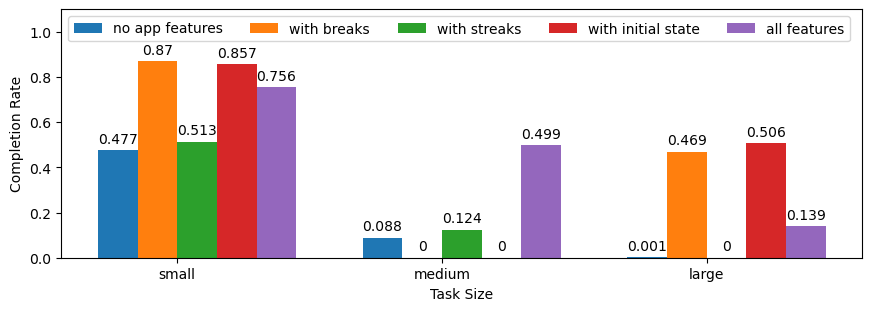

In [741]:
import matplotlib.pyplot as plt
import numpy as np

species = barx
penguin_means = bary
x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(9,3))

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset - width/2, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Completion Rate')
# ax.set_title('Number of tasks completed')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=5)
ax.set_ylim(0, 1.1)
ax.set_xlabel("Task Size")

plt.show()

## Plot 2:  Transition matrix of successful settings

In [253]:
episode.mdp.transitions[1]

array([[0.        , 0.81818182, 0.45      , 0.18181818],
       [0.81818182, 0.        , 0.45      , 0.18181818],
       [0.45      , 0.45      , 0.        , 0.1       ],
       [0.5       , 0.5       , 0.1       , 0.        ]])

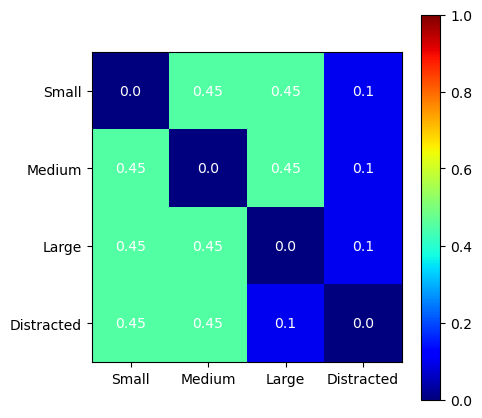

In [242]:
data = episode.mdp.transitions[1]

labels = ["Small", "Medium", "Large", "Distracted"]
f, ax = plt.subplots(1,1,figsize=(5,5))
im = ax.imshow(data, cmap='jet', vmin=0, vmax = 1)
ax.set_xticks(np.arange(4), labels=labels)
ax.set_yticks(np.arange(4), labels=labels)
for i in range(4):
    for j in range(4):
        text = ax.text(j, i, np.around(data[i,j], decimals=2),
                       ha="center", va="center", color="w")
plt.colorbar(im, ax=ax)


 ## Line Plot 3: Sweep across break/streak lengths

In [652]:
self = episode.mdp


get_active_states(self.states)




{1: <__main__.State at 0x14e3b5b10>,
 2: <__main__.State at 0x157aac310>,
 3: <__main__.State at 0x133530a00>}

In [653]:
episode.mdp.init_transition

{0: array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 1: array([[0.  , 0.45, 0.45, 0.1 ],
        [0.45, 0.  , 0.45, 0.1 ],
        [0.45, 0.45, 0.  , 0.1 ],
        [0.45, 0.45, 0.1 , 0.  ]])}

In [654]:
episode.mdp.transitions

{0: array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 1: array([[0.        , 0.45      , 0.45      , 0.1       ],
        [0.45      , 0.        , 0.9       , 0.1       ],
        [0.45      , 0.9       , 0.        , 0.1       ],
        [0.45      , 0.81818182, 0.18181818, 0.        ]])}

In [722]:


import time
    
# have a way of constructing valid transition matrices so that each row is a valid probability. 
# How many "sliders" or "knobs" do you need? 


lengths = [10,20, 30, 40, 50, 60]
# lengths=[10]

t1 = time.time()
initial_state = None

EP = []

for l in lengths:
    mdp = MDP(Reward, 
              Task_Timer,  
              transitions, 
              initial_state, 
              Break=False,
              break_length = l,
              Streaks=True,
             streak_length=l)

    agent = Agent(epsilon=0.1, learning_rate=1) # epsilon is the probability of "exploring" vs exploiting
    n_episodes = 300
    episode = Episodes(mdp, agent, n_episodes)
    episode.run()
    time.time() - t1
    EP.append(episode)

# baryB = get_bary(episode)



    

Running 300 episodes
	Episode: 0	Score: 3477
	Episode: 1	Score: 61087
	Episode: 2	Score: 61142
	Episode: 3	Score: 3485
	Episode: 4	Score: 61175
	Episode: 5	Score: 61208
	Episode: 6	Score: 3463
	Episode: 7	Score: -106


/var/folders/sg/6wtlzgws3s53sr8zwb1lxs3w0000gn/T/ipykernel_43875/3344027902.py:224: RuntimeWarning: invalid value encountered in divide
  return p/p.sum()*norm


	Episode: 8	Score: 3551
	Episode: 9	Score: 61098
	Episode: 10	Score: 3496
	Episode: 11	Score: 61164
	Episode: 12	Score: 61142
	Episode: 13	Score: 61104
	Episode: 14	Score: -106
	Episode: 15	Score: 61175
	Episode: 16	Score: 61186
	Episode: 17	Score: 61208
	Episode: 18	Score: 61142
	Episode: 19	Score: 61153
	Episode: 20	Score: 3474
	Episode: 21	Score: 3474
	Episode: 22	Score: 3452
	Episode: 23	Score: 3441
	Episode: 24	Score: 61087
	Episode: 25	Score: 61002
	Episode: 26	Score: 61120
	Episode: 27	Score: 57529
	Episode: 28	Score: 61208
	Episode: 29	Score: 3485
	Episode: 30	Score: 61090
	Episode: 31	Score: 61153
	Episode: 32	Score: 61153
	Episode: 33	Score: 3529
	Episode: 34	Score: 61098
	Episode: 35	Score: 61142
	Episode: 36	Score: 3496
	Episode: 37	Score: 61153
	Episode: 38	Score: 61087
	Episode: 39	Score: 3474
	Episode: 40	Score: 61134
	Episode: 41	Score: -117
	Episode: 42	Score: 3485
	Episode: 43	Score: 3463
	Episode: 44	Score: 61230
	Episode: 45	Score: 3463
	Episode: 46	Score: 61065
	Ep

	Episode: 24	Score: 17703
	Episode: 25	Score: 17717
	Episode: 26	Score: 17634
	Episode: 27	Score: 17725
	Episode: 28	Score: 17755
	Episode: 29	Score: 17722
	Episode: 30	Score: 17722
	Episode: 31	Score: 17689
	Episode: 32	Score: 17747
	Episode: 33	Score: 17703
	Episode: 34	Score: 17700
	Episode: 35	Score: 17758
	Episode: 36	Score: 17684
	Episode: 37	Score: 3243
	Episode: 38	Score: 17733
	Episode: 39	Score: 17689
	Episode: 40	Score: 17711
	Episode: 41	Score: 17714
	Episode: 42	Score: 17689
	Episode: 43	Score: 17678
	Episode: 44	Score: 17714
	Episode: 45	Score: 17744
	Episode: 46	Score: 17755
	Episode: 47	Score: 17722
	Episode: 48	Score: 17711
	Episode: 49	Score: 17722
	Episode: 50	Score: 17700
	Episode: 51	Score: 17777
	Episode: 52	Score: 17670
	Episode: 53	Score: 17733
	Episode: 54	Score: 17733
	Episode: 55	Score: 17700
	Episode: 56	Score: 17744
	Episode: 57	Score: 14021
	Episode: 58	Score: 17733
	Episode: 59	Score: 17700
	Episode: 60	Score: 17700
	Episode: 61	Score: 17755
	Episode: 62	

	Episode: 33	Score: 13933
	Episode: 34	Score: 13955
	Episode: 35	Score: 13944
	Episode: 36	Score: 13933
	Episode: 37	Score: 13944
	Episode: 38	Score: 13944
	Episode: 39	Score: 13944
	Episode: 40	Score: 13944
	Episode: 41	Score: 13933
	Episode: 42	Score: 13955
	Episode: 43	Score: 13944
	Episode: 44	Score: 13955
	Episode: 45	Score: 13950
	Episode: 46	Score: 13944
	Episode: 47	Score: 13925
	Episode: 48	Score: 13955
	Episode: 49	Score: 13933
	Episode: 50	Score: 13933
	Episode: 51	Score: 13955
	Episode: 52	Score: 13933
	Episode: 53	Score: 13961
	Episode: 54	Score: 13933
	Episode: 55	Score: 13933
	Episode: 56	Score: 13933
	Episode: 57	Score: 13936
	Episode: 58	Score: 13933
	Episode: 59	Score: 13944
	Episode: 60	Score: 13955
	Episode: 61	Score: 13947
	Episode: 62	Score: 13955
	Episode: 63	Score: 13933
	Episode: 64	Score: 13933
	Episode: 65	Score: 13936
	Episode: 66	Score: 13947
	Episode: 67	Score: 13933
	Episode: 68	Score: 13933
	Episode: 69	Score: 13947
	Episode: 70	Score: 13944
	Episode: 71

	Episode: 46	Score: -458
	Episode: 47	Score: -469
	Episode: 48	Score: 17678
	Episode: 49	Score: 3166
	Episode: 50	Score: -458
	Episode: 51	Score: -436
	Episode: 52	Score: -436
	Episode: 53	Score: 3177
	Episode: 54	Score: 3177
	Episode: 55	Score: -436
	Episode: 56	Score: -447
	Episode: 57	Score: 3177
	Episode: 58	Score: -447
	Episode: 59	Score: 3166
	Episode: 60	Score: 3166
	Episode: 61	Score: -425
	Episode: 62	Score: 13955
	Episode: 63	Score: 3144
	Episode: 64	Score: 3177
	Episode: 65	Score: -425
	Episode: 66	Score: -436
	Episode: 67	Score: 3177
	Episode: 68	Score: -447
	Episode: 69	Score: 13955
	Episode: 70	Score: -436
	Episode: 71	Score: -458
	Episode: 72	Score: 3177
	Episode: 73	Score: 3133
	Episode: 74	Score: -458
	Episode: 75	Score: 3155
	Episode: 76	Score: 3133
	Episode: 77	Score: 3155
	Episode: 78	Score: -447
	Episode: 79	Score: 3166
	Episode: 80	Score: -458
	Episode: 81	Score: 3177
	Episode: 82	Score: -458
	Episode: 83	Score: 3188
	Episode: 84	Score: -466
	Episode: 85	Score: -4

	Episode: 71	Score: -469
	Episode: 72	Score: -469
	Episode: 73	Score: -469
	Episode: 74	Score: 13933
	Episode: 75	Score: -480
	Episode: 76	Score: -469
	Episode: 77	Score: -447
	Episode: 78	Score: -447
	Episode: 79	Score: 13966
	Episode: 80	Score: 13955
	Episode: 81	Score: -458
	Episode: 82	Score: -458
	Episode: 83	Score: -469
	Episode: 84	Score: -480
	Episode: 85	Score: 13944
	Episode: 86	Score: 13933
	Episode: 87	Score: -447
	Episode: 88	Score: -480
	Episode: 89	Score: -469
	Episode: 90	Score: -436
	Episode: 91	Score: -469
	Episode: 92	Score: 13922
	Episode: 93	Score: -436
	Episode: 94	Score: -458
	Episode: 95	Score: 13944
	Episode: 96	Score: -458
	Episode: 97	Score: -480
	Episode: 98	Score: 13955
	Episode: 99	Score: 13933
	Episode: 100	Score: -458
	Episode: 101	Score: 57155
	Episode: 102	Score: -480
	Episode: 103	Score: 13944
	Episode: 104	Score: -469
	Episode: 105	Score: -469
	Episode: 106	Score: -480
	Episode: 107	Score: 13955
	Episode: 108	Score: 13966
	Episode: 109	Score: 13944
	

	Episode: 95	Score: -448
	Episode: 96	Score: -437
	Episode: 97	Score: -428
	Episode: 98	Score: 13951
	Episode: 99	Score: -448
	Episode: 100	Score: -438
	Episode: 101	Score: -443
	Episode: 102	Score: -457
	Episode: 103	Score: -456
	Episode: 104	Score: -445
	Episode: 105	Score: -460
	Episode: 106	Score: 71677
	Episode: 107	Score: 13959
	Episode: 108	Score: -451
	Episode: 109	Score: -465
	Episode: 110	Score: -450
	Episode: 111	Score: -460
	Episode: 112	Score: 13959
	Episode: 113	Score: -468
	Episode: 114	Score: 13937
	Episode: 115	Score: -468
	Episode: 116	Score: -457
	Episode: 117	Score: -462
	Episode: 118	Score: -457
	Episode: 119	Score: 13947
	Episode: 120	Score: 13964
	Episode: 121	Score: 13939
	Episode: 122	Score: -477
	Episode: 123	Score: -471
	Episode: 124	Score: -457
	Episode: 125	Score: -468
	Episode: 126	Score: -462
	Episode: 127	Score: -445
	Episode: 128	Score: -460
	Episode: 129	Score: 13922
	Episode: 130	Score: 13942
	Episode: 131	Score: -460
	Episode: 132	Score: -453
	Episod

In [723]:
# mdp = MDP(Reward, 
#           Task_Timer,  
#           transitions, 
#           initial_state, 
#           Break=True,
#           break_length = l,
#           Streaks=False,
#          streak_length=10)

# agent = Agent(epsilon=0.10, learning_rate=0.5) # epsilon is the probability of "exploring" vs exploiting
# n_episodes = 100
# episode = Episodes(mdp, agent, n_episodes)
# episode.run()


In [724]:
episode.mdp.transitions


{0: array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 1: array([[0.  , 0.45, 0.45, 0.1 ],
        [0.45, 0.  , 0.45, 0.1 ],
        [0.45, 0.45, 0.  , 0.1 ],
        [0.45, 0.45, 0.1 , 0.  ]])}

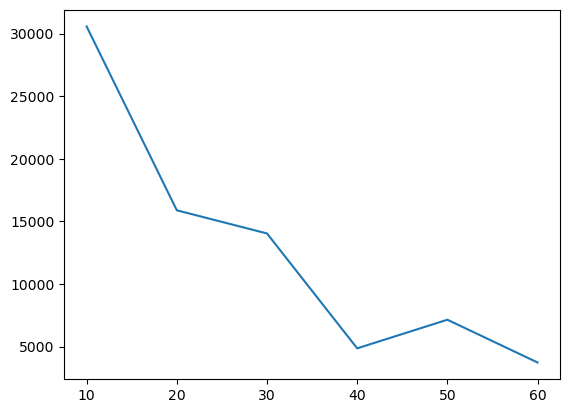

In [725]:
score = [np.mean(e.score) for e in EP]

    
plt.plot(lengths, score)
plt.show()

In [726]:
e.score

[57158,
 -453,
 -432,
 57140,
 -459,
 -450,
 57164,
 -420,
 -420,
 57161,
 57143,
 57137,
 -471,
 -453,
 -441,
 -441,
 -438,
 -462,
 -441,
 -453,
 -459,
 -435,
 -444,
 -453,
 -465,
 57149,
 57149,
 -450,
 -453,
 57152,
 -438,
 -435,
 57143,
 57167,
 57143,
 57158,
 -438,
 -456,
 57134,
 -468,
 57158,
 -441,
 -450,
 -453,
 57149,
 -447,
 -435,
 -438,
 -453,
 57167,
 57158,
 -438,
 -438,
 -462,
 57152,
 -444,
 57140,
 -423,
 -462,
 -441,
 57149,
 -459,
 -465,
 57137,
 57152,
 -465,
 -459,
 -438,
 -420,
 -474,
 -453,
 -444,
 57158,
 -435,
 -429,
 -432,
 -429,
 57140,
 -441,
 -450,
 -456,
 57140,
 -456,
 57143,
 -426,
 -435,
 -420,
 -453,
 -456,
 -429,
 57161,
 -459,
 57167,
 -423,
 -444,
 -453,
 -456,
 -453,
 -441,
 57140,
 57140,
 -456,
 57161,
 -450,
 57164,
 -447,
 -432,
 57161,
 -444,
 -444,
 57152,
 57167,
 57161,
 57173,
 57137,
 -444,
 57149,
 -444,
 -465,
 -420,
 -462,
 -432,
 57131,
 57155,
 -417,
 -426,
 -462,
 -462,
 57167,
 57155,
 57131,
 57146,
 -462,
 -459,
 -447,
 57149,
 

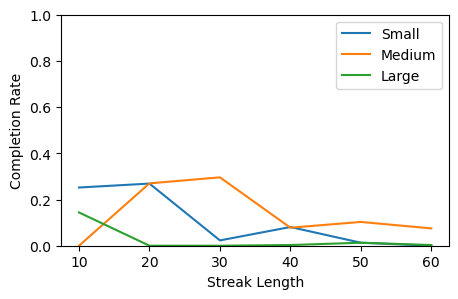

In [742]:
plt.figure(figsize=(5,3))
ax = plt.plot(np.c_[[get_bary(e) for e in EP]]/n_episodes)
plt.xticks(np.arange(len(lengths)), lengths)
plt.xlabel("Streak Length")
plt.ylabel("Completion Rate")
plt.ylim(0,1)
plt.legend(["Small","Medium", "Large"] )
plt.show()

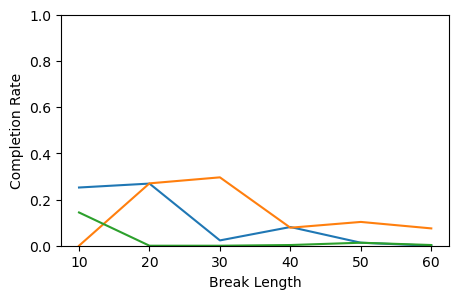

In [743]:
plt.figure(figsize=(5,3))
plt.plot(np.c_[[get_bary(e) for e in EP]]/n_episodes)
plt.xticks(np.arange(len(lengths)), lengths)
plt.xlabel("Break Length")
plt.ylabel("Completion Rate")
plt.ylim(0,1)
plt.show()



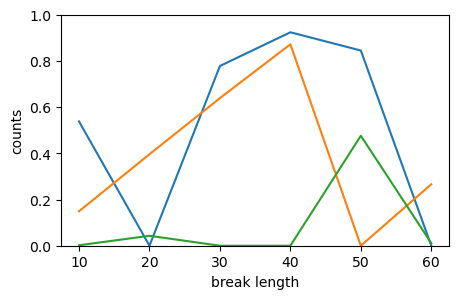

In [682]:
plt.figure(figsize=(5,3))
plt.plot(np.c_[[get_bary(e) for e in EP]]/1000)
plt.xticks(np.arange(len(lengths)), lengths)
plt.xlabel("break length")
plt.ylabel("counts")
plt.ylim(0,1)
plt.show()

In [ ]:

# # take 

# barx = ["small", "medium", "large"]





# bar1 = plt.bar(barx, bary, label="no break/streaks")
# plt.legend()
# plt.show()
    


## Random Search

In [ ]:
import random as rand
# n_samples for random search = 4,000
def RandomSearch(transitions, n_samples=4000):
    params = {}
    
    for i in range(n_samples):
        print(i)
        
        initial_state = rand.randrange(0,2)
        Break = bool(rand.getrandbits(1))
        break_length = rand.randrange(5,60,5)
        Streaks = bool(rand.getrandbits(1))
        streak_length = rand.randrange(10,90,5)
        transitions = {0: transitions_0,
               1: []}
        
        offtask = 0.1
        rand_1 = rand.uniform(0, 1-offtask)
        rand_2 = rand.uniform(0, 1-offtask)
        rand_3 = rand.uniform(0, 1-offtask)
        rand_4 = npr.dirichlet(np.ones(3),size=1)[0]
        
        transitions[1] = [[0., rand_1, 1-offtask-rand_1, offtask],
                              [rand_2, 0., 1-offtask-rand_2, offtask],
                              [rand_3, 1-offtask-rand_3, 0., offtask],
                              [rand_4[0], rand_4[1], rand_4[2], 0.]]

        mdp = MDP(Reward, 
          Task_Timer,  
          transitions, 
          initial_state, 
          Break=True,
          break_length = 10,
          Streaks=False,
          streak_length=10,
          streak_reward=30)
        print(transitions[1][0][3])
        agent = Agent(epsilon=0.1, learning_rate=0.5) # epsilon is the probability of "exploring" vs exploiting
        n_episodes = 50
        episode = Episodes(mdp, agent, n_episodes)
        episode.run()
        expected_score = np.median(episode.score)
        
        params[i] = {"transition parameter 1": rand_1,
                    "transition parameter 2": rand_2,
                    "transition parameter 3": rand_3,
                    "transition parameter 4": rand_4[0],
                    "transition parameter 5": rand_4[1],
                    "transition parameter 6": rand_4[2],
                    "break": Break,
                    "streaks": Streaks,
                    "break_length": break_length,
                    "streak_length": streak_length,
                    "expected score": expected_score}
        
    return params

In [ ]:
import json

params = RandomSearch(transitions, 4000)
with open("random_search.json", "w") as write_file:
    json.dump(params, write_file, indent=4)

In [ ]:
expected_score = np.median(episode.score)
print(expected_score)

In [ ]:

# build a dictionary of dictionaries
# key is the "experiment", item is another dictionary of the parameters


{0: {"transition parameter 1": 0.6
    "transition parameter 2":0.3
    "transition parameter 3": 0.2
    "transition parameter 4": 0.1
    "transition parameter 5": 0.4
    "break": True/False,
    "streaks": True/False,
    "break_length": 20,
    "streak_length": 30,
    "expected score": -100},
1: ,
2:,
}



In [ ]:

# distribution of scores (baseline set up)
plt.figure(figsize=(5,3))
plt.hist(episode.score, bins=50)
plt.xlabel('score')
plt.show()

plt.figure(figsize=(5,3))
plt.plot(episode.score)
plt.show()

In [ ]:

# distribution of scores (baseline set up)
plt.figure(figsize=(5,3))
plt.hist(episode.score, bins=50)
plt.xlabel('score')
plt.show()

plt.figure(figsize=(5,3))
plt.plot(episode.score)
plt.show()

In [ ]:
# print(test.prog)
# print(test.actions)
# print(test.states)
# print(test.rewards)
# print(test.on_break)


In [ ]:
#  simple episode
# prog = []
# actions = []
# states = []
# rewards = []
# on_break = []
# on_break2 = []
# time_horizon = 480

# # get initial state/ set reward to 0
# s0 = mdp.get_state_ix()
# # s0 = mdp.get_state()
# r = 0
# agent = Agent()
# for i in range(time_horizon):
# #     a = fake_agent(s0, r)
# #     a = agent(s0, r)
    
#     a = agent.choose_action(s0)
#     s1, r = mdp(a)
#     s1 = mdp.get_state_ix()
#     agent.update(s0, s1, r)

#     # Q update
# #     break
    
#     s0 = s1

    
#     p_ = [self.states[k].progress for k in range(4)]
    
#     prog.append(p_)
#     actions.append(a)
#     states.append(self.current_state_ix)
#     rewards.append(r)
#     on_break.append(self.on_break)
#     on_break2.append(self.task_timer.on_break)
    
    
#     active_states = get_active_states(self.states,True)
#     if len(active_states) == 1:
#         break


# print(f'a:\t{a}')
# print(print_progress(self.states))

In [ ]:

f, axs = plt.subplots(5,1, figsize=(10,7), sharex=True)

# index the episode you want to visualize
ep = 0

axs[0].plot(episode.states[ep])
axs[0].set_ylabel('states')
axs[1].plot(episode.actions[ep])
axs[1].set_ylabel('actions')
axs[2].plot(np.array(episode.prog[ep])[:,:-1])
axs[2].set_ylabel('progress')
axs[3].plot(np.cumsum(episode.rewards[ep]))
axs[3].set_ylabel('total rewards')
axs[4].plot(episode.on_break[ep])
axs[4].set_ylabel('on break')

# axs[3].set_yscale('log')

plt.show()

In [ ]:
agent.Qp